# Importing required libraries

In [56]:
import os
import random
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd
from huggingface_hub import login
import sentencepiece
import accelerate
import shutil
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AlbertTokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score


# Loading the pre-processed Dataset 


In [3]:
# Loading the cleaned CSV
CLEAN_CSV_PATH = "hindi_hatespeech_cleaned.csv" 

df = pd.read_csv(CLEAN_CSV_PATH)

print("Loaded cleaned dataset")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nLabel distribution (labels):")
print(df["labels"].value_counts())

Loaded cleaned dataset
Shape: (14127, 3)

Columns: ['text', 'cleaned_text', 'labels']

Label distribution (labels):
labels
0    12257
1     1870
Name: count, dtype: int64


In [4]:
# Copying the dataframe to use only cleaned version for model training
df_model = df[["cleaned_text", "labels"]].rename(columns={"cleaned_text": "text"})

print("\nHead of df_model (used for training):")
print(df_model.head())

# Converting to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df_model, preserve_index=False)

print("\nHF Dataset overview:")
print(hf_dataset)



Head of df_model (used for training):
                                                text  labels
0  वक्त, इन्सान और इंग्लैंड का मौसम आपको कभी भी ध...       0
1  कांग्रेस के इस कमीने की करतूत को देखिए देश की ...       0
2  पाकिस्तान को फेकना था फेका गया। जो हार कर भी द...       0
3  जो शब्द तूम आज किसी और औरत के लिए यूज कर रहे व...       0
4  नेता जी हम समाजवादी सिपाही हमेशा आपके साथ है आ...       0

HF Dataset overview:
Dataset({
    features: ['text', 'labels'],
    num_rows: 14127
})


# Splitting the dataset

In [5]:
# Splitting 10% test and 90% train+val
split_1 = hf_dataset.train_test_split(test_size=0.10, seed=42)
temp_train = split_1["train"]
test_ds = split_1["test"]

# Carving out the split for validation
val_fraction_from_temp = 0.10 / 0.90  # ≈ 0.1111

split_2 = temp_train.train_test_split(test_size=val_fraction_from_temp, seed=42)
train_ds = split_2["train"]
val_ds = split_2["test"]

# Packing into a DatasetDict
datasets_splits = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(datasets_splits)
for split_name, ds in datasets_splits.items():
    print(split_name, len(ds))

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 11301
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1413
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1413
    })
})
train 11301
validation 1413
test 1413


# Tokenizing the dataset

In [6]:
# Defining the model
MODEL_NAME = "ai4bharat/indic-bert"  

# Defining the tokenizer
tokenizer = AlbertTokenizer.from_pretrained(MODEL_NAME)
print("Loaded tokenizer:", type(tokenizer))

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

Loaded tokenizer: <class 'transformers.models.albert.tokenization_albert.AlbertTokenizer'>


If you are unable to load the tokenizer, ensure you have logged into HuggingFace

In [7]:
# Writing a funciton to tokenize dataset splits
def tokenize_splits(
    datasets_splits,
    tokenizer,
    text_column: str = "text",
    max_length: int = 128,
):
    """
    Tokenise all splits using the given tokenizer.
    - Uses `text_column` (here = 'text' = cleaned_text)
    - Keeps `labels` as-is
    """
    print("Original splits:")
    print(datasets_splits)

    def tokenize_batch(batch):
        # Ensuring everything is a string to avoid the previous ValueError
        texts = [str(t) if t is not None else "" for t in batch[text_column]]
        return tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
        )

    tokenized = datasets_splits.map(tokenize_batch, batched=True)

    print("\nTokenised splits:")
    print(tokenized)

    return tokenized

In [8]:
# Tokenizing the splits
tokenized_datasets = tokenize_splits(
    datasets_splits=datasets_splits,
    tokenizer=tokenizer,
    text_column="text",      
    max_length=128
)

Original splits:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 11301
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1413
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1413
    })
})


Map:   0%|          | 0/11301 [00:00<?, ? examples/s]

Map:   0%|          | 0/1413 [00:00<?, ? examples/s]

Map:   0%|          | 0/1413 [00:00<?, ? examples/s]


Tokenised splits:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11301
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1413
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1413
    })
})


# Computing Class weights 

In [9]:
# Defining a function to compute class weights 
def compute_class_weights_from_dataset(tokenized_datasets):
    """
    Compute inverse-frequency class weights from the TRAIN split.
    Returns a torch.FloatTensor of shape [num_labels].
    """
    train_labels = np.array(tokenized_datasets["train"]["labels"])
    
    # Counting occurrences of each class
    unique, counts = np.unique(train_labels, return_counts=True)
    num_classes = unique.shape[0]
    
    class_counts = np.zeros(num_classes, dtype=np.float32)
    for u, c in zip(unique, counts):
        class_counts[int(u)] = c
    
    # Applying inverse-frequency weighting using the formula w_i = N / (num_classes * count_i)
    total = class_counts.sum()
    weights = total / (num_classes * class_counts)
    
    print("Class counts:", class_counts)
    print("Class weights:", weights)
    
    return torch.tensor(weights, dtype=torch.float32)

In [10]:
# Applying class weights
class_weights = compute_class_weights_from_dataset(tokenized_datasets)

Class counts: [9796. 1505.]
Class weights: [0.5768171 3.7544851]


# Defining the model

In [11]:
# Defining a function to build IndicBERT for classification
def build_indicbert_model(model_name: str, num_labels: int = 2):
    """
    Load IndicBERT as a sequence classification model.
    
    Parameters
    ----------
    model_name : str
        Hugging Face model name, e.g. "ai4bharat/indic-bert".
    num_labels : int
        Number of output labels (binary hate / non-hate → 2).
    
    Returns
    -------
    model : AutoModelForSequenceClassification
    """
    id2label = {0: "non-hate", 1: "hate"}
    label2id = {"non-hate": 0, "hate": 1}

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    print(f"Loaded IndicBERT model from: {model_name}")
    return model

In [12]:
# Calling the function to build the model
model = build_indicbert_model(MODEL_NAME, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded IndicBERT model from: ai4bharat/indic-bert


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

# Model Training

In [13]:
# Defining a function for evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1
    )
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

In [14]:
# Defining a function to train the model
def train_indicbert_weighted(
    model,
    tokenized_datasets: DatasetDict,
    tokenizer,
    class_weights,              # numpy array [w_nonhate, w_hate]
    output_dir: str = "./indicbert_hate_weighted",
    num_epochs: int = 3,
    batch_size: int = 32,
    lr: float = 2e-5,
):
    """
    Train IndicBERT with class-weighted loss to handle label imbalance.
    Assumes labels are 0 (non-hate) and 1 (hate).
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Training on device: {device}")

    # Preparing TrainingArguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
    )

    # Turning weights into tensor once
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

    # Defining custom Trainer with weighted loss ---
    class WeightedTrainer(Trainer):
        def __init__(self, class_weights, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # store weights as tensor
            self.class_weights = class_weights

        def compute_loss(
            self,
            model,
            inputs,
            return_outputs: bool = False,
            **kwargs,                 # absorbing extra kwargs like num_items_in_batch
        ):
            labels = inputs.get("labels")
            # forward pass
            outputs = model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                token_type_ids=inputs.get("token_type_ids", None),
            )
            logits = outputs.logits

            # building weighted CE loss
            weights = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=weights)
            loss = loss_fct(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
            )

            return (loss, outputs) if return_outputs else loss

    trainer = WeightedTrainer(
        class_weights=class_weights_tensor,
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Training the model
    print("\n============================================================")
    print("STARTING INDICBERT TRAINING (CLASS-WEIGHTED)")
    print("============================================================")
    trainer.train()
    print("\n✅ IndicBERT (weighted) training finished!")

    # Evaluating the model
    print("\nEvaluating on validation set...")
    val_metrics = trainer.evaluate(tokenized_datasets["validation"])
    print(val_metrics)

    print("\nEvaluating on test set...")
    test_metrics = trainer.evaluate(tokenized_datasets["test"])
    print(test_metrics)

    return trainer, val_metrics, test_metrics

In [15]:
# Calling the function for model training
trainer, val_metrics, test_metrics = train_indicbert_weighted(
    model=model,
    tokenized_datasets=tokenized_datasets,
    tokenizer=tokenizer,
    class_weights=class_weights,   # your numpy array [w_0, w_1]
    output_dir="./indicbert_hate_weighted",
    num_epochs=3,
    batch_size=32,
    lr=2e-5,
)

Training on device: cuda

STARTING INDICBERT TRAINING (CLASS-WEIGHTED)


/tmp/ipykernel_7722/2018058384.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
/tmp/ipykernel_7722/2018058384.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.585400,0.614895,0.790517,0.297203,0.472222,0.364807
2,0.551100,0.575719,0.738146,0.286996,0.711111,0.408946
3,0.480700,0.600406,0.780609,0.308824,0.583333,0.403846



✅ IndicBERT (weighted) training finished!

Evaluating on validation set...


{'eval_loss': 0.5757194757461548, 'eval_accuracy': 0.7381457891012031, 'eval_precision': 0.28699551569506726, 'eval_recall': 0.7111111111111111, 'eval_f1': 0.40894568690095845, 'eval_runtime': 8.0731, 'eval_samples_per_second': 175.027, 'eval_steps_per_second': 5.574, 'epoch': 3.0}

Evaluating on test set...
{'eval_loss': 0.5597328543663025, 'eval_accuracy': 0.7501769285208776, 'eval_precision': 0.3108108108108108, 'eval_recall': 0.745945945945946, 'eval_f1': 0.43879173290937995, 'eval_runtime': 8.0994, 'eval_samples_per_second': 174.458, 'eval_steps_per_second': 5.556, 'epoch': 3.0}


# Version 2 

# Softening Class weights

In [16]:
# Helper funciton to soften the weights
def soften_class_weights(raw_weights: torch.Tensor, alpha: float = 0.5) -> torch.Tensor:
    """
    Soften class weights to avoid over-penalising the majority/minority.
    Example: w_soft = (w ** alpha), then re-scaled so mean ~ 1.
    
    Parameters
    ----------
    raw_weights : torch.Tensor
        Original inverse-frequency weights (shape [num_labels]).
    alpha : float
        Exponent in (0,1]. Lower = softer. 0.5 = square root.
    """
    w = raw_weights.clone().detach().float()
    w_soft = w ** alpha              # e.g. sqrt
    w_soft = w_soft * (w.mean() / w_soft.mean())  # rescale so average stays similar
    return w_soft

In [17]:
# Defining weighted trainer again, for the version 2
class WeightedTrainerV2(Trainer):
    def __init__(self, class_weights: torch.Tensor = None, *args, **kwargs):
        """
        Trainer that uses class-weighted CrossEntropyLoss.
        `class_weights` should be a 1D tensor [num_labels].
        """
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom loss:
        - Extracts labels
        - Runs model
        - Applies CrossEntropyLoss with class weights
        """
        labels = inputs.pop("labels")       # shape [batch]
        outputs = model(**inputs)           # forward pass
        logits = outputs.logits             # [batch, num_labels]

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

# Model Training (with softer class weights)

In [18]:
# Defining a function for model training(with softer class weights)
def train_indicbert_v2(
    model,
    tokenized_datasets,
    tokenizer,
    class_weights: torch.Tensor,
    output_dir: str = "./indicbert_hate_model_v2",
    num_epochs: int = 3,
    batch_size: int = 16,
    learning_rate: float = 2e-5,
):
    """
    Version 2 training:
    - Uses softened class weights
    - Cosine learning-rate scheduler
    - Same metrics as v1
    """

    # Softening class weights
    soft_weights = soften_class_weights(class_weights, alpha=0.5)
    print("Raw weights:     ", class_weights)
    print("Softened weights:", soft_weights)

    # Defining TrainingArguments with learning rate scheduler
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",  
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        logging_dir=f"{output_dir}/logs",
        report_to="none",
    )

    # Defining compute_metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)

        acc = accuracy_score(labels, preds)
        # hate class = 1
        prec, rec, f1, _ = precision_recall_fscore_support(
            labels, preds, labels=[1], average="macro", zero_division=0
        )
        return {
            "accuracy": acc,
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
        }

    # Building trainer
    trainer = WeightedTrainerV2(
        class_weights=soft_weights,
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Training the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"\nTraining on device: {device}")
    print("\n============================================================")
    print("STARTING INDICBERT TRAINING — VERSION 2 (soft weights + scheduler)")
    print("============================================================")
    trainer.train()
    print("\n✅ IndicBERT Version 2 training finished!")

    # Evaluating the model on validation and test
    print("\nEvaluating on validation set (best checkpoint)...")
    val_metrics = trainer.evaluate(tokenized_datasets["validation"])
    print(val_metrics)

    print("\nEvaluating on test set...")
    test_metrics = trainer.evaluate(tokenized_datasets["test"])
    print(test_metrics)

    return trainer, val_metrics, test_metrics

In [20]:
# Computing class weights from TRAIN split (same function as used before)
class_weights = compute_class_weights_from_dataset(tokenized_datasets)
print("Class weights from training data:", class_weights)

# Training using the second version of the training function
trainer_v2, val_v2, test_v2 = train_indicbert_v2(
    model=model,
    tokenized_datasets=tokenized_datasets,
    tokenizer=tokenizer,
    class_weights=class_weights,   
    output_dir="./indicbert_hate_model_v2",
    num_epochs=3,
    batch_size=16,
    learning_rate=2e-5,           
)


Class counts: [9796. 1505.]
Class weights: [0.5768171 3.7544851]
Class weights from training data: tensor([0.5768, 3.7545])
Raw weights:      tensor([0.5768, 3.7545])
Softened weights: tensor([1.2196, 3.1117])

Training on device: cuda

STARTING INDICBERT TRAINING — VERSION 2 (soft weights + scheduler)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_7722/2866183204.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainerV2.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.365700,0.666894,0.837933,0.370370,0.388889,0.379404
2,0.347200,0.871542,0.831564,0.377119,0.494444,0.427885
3,0.217900,1.116221,0.848549,0.386667,0.322222,0.351515



✅ IndicBERT Version 2 training finished!

Evaluating on validation set (best checkpoint)...


{'eval_loss': 0.8715417981147766, 'eval_accuracy': 0.8315640481245576, 'eval_precision': 0.3771186440677966, 'eval_recall': 0.49444444444444446, 'eval_f1': 0.42788461538461536, 'eval_runtime': 8.5483, 'eval_samples_per_second': 165.296, 'eval_steps_per_second': 10.411, 'epoch': 3.0}

Evaluating on test set...
{'eval_loss': 0.8189060688018799, 'eval_accuracy': 0.8237791932059448, 'eval_precision': 0.3620689655172414, 'eval_recall': 0.4540540540540541, 'eval_f1': 0.4028776978417266, 'eval_runtime': 8.6012, 'eval_samples_per_second': 164.279, 'eval_steps_per_second': 10.347, 'epoch': 3.0}


# Saving Predictions

In [33]:
# Loading the model saved at the best checkpoint
BEST_DIR   = "./indicbert_hate_model_v2/checkpoint-1414"
FINAL_DIR  = "./indicbert_hate_model_v2_final"

shutil.copytree(BEST_DIR, FINAL_DIR)
print("✅ Copied best checkpoint to:", FINAL_DIR)

✅ Copied best checkpoint to: ./indicbert_hate_model_v2_final


In [34]:
# Using final trainer object here (e.g. trainer_v2)
test_output = trainer_v2.predict(tokenized_datasets["test"])

logits = test_output.predictions          
y_true = test_output.label_ids            

# Converting logits to probabilities
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
y_pred = np.argmax(probs, axis=1)         
hate_probs = probs[:, 1]                


# Plotting results

<Figure size 500x500 with 0 Axes>

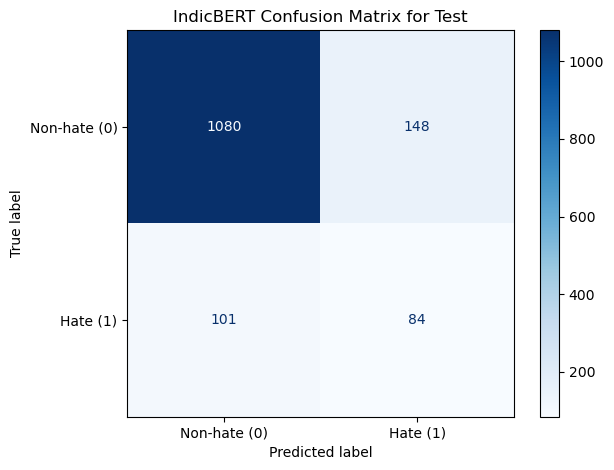

In [40]:
# Plotting confusion matrix for the test set
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-hate (0)", "Hate (1)"]
)

plt.figure(figsize=(5, 5))
disp.plot(values_format="d", cmap="Blues")
plt.title("IndicBERT Confusion Matrix for Test")
plt.tight_layout()
plt.show()

In [44]:
# Obtaining the Classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=["Non-hate (0)", "Hate (1)"]
))


              precision    recall  f1-score   support

Non-hate (0)       0.91      0.88      0.90      1228
    Hate (1)       0.36      0.45      0.40       185

    accuracy                           0.82      1413
   macro avg       0.64      0.67      0.65      1413
weighted avg       0.84      0.82      0.83      1413



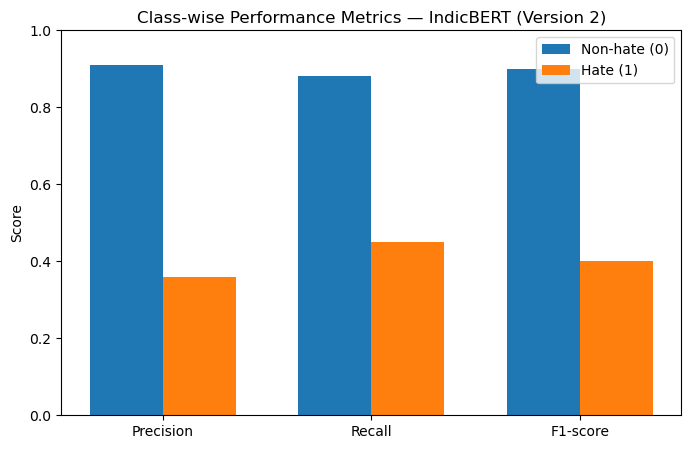

In [46]:
# Plotting class wise performance metrics
metrics = ["Precision", "Recall", "F1-score"]
non_hate = [0.91, 0.88, 0.90]
hate     = [0.36, 0.45, 0.40]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, non_hate, width, label="Non-hate (0)")
plt.bar(x + width/2, hate, width, label="Hate (1)")

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Class-wise Performance Metrics — IndicBERT (Version 2)")
plt.legend()
plt.show()


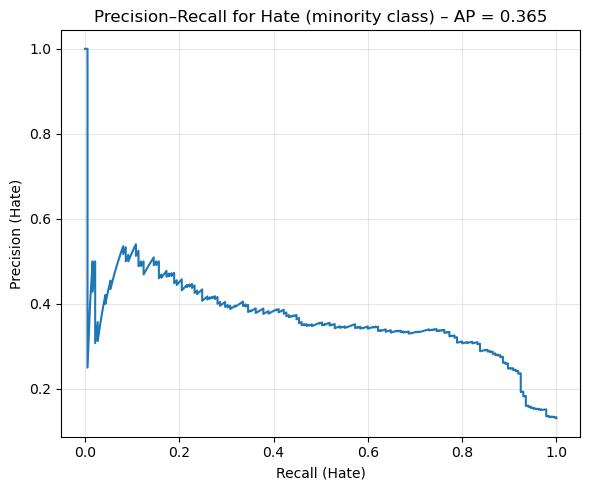

In [52]:
# Precision and recall for minority class
precision, recall, thresholds = precision_recall_curve(y_true, hate_probs, pos_label=1)
ap = average_precision_score(y_true, hate_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (Hate)")
plt.ylabel("Precision (Hate)")
plt.title(f"Precision–Recall for Hate (minority class) – AP = {ap:.3f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

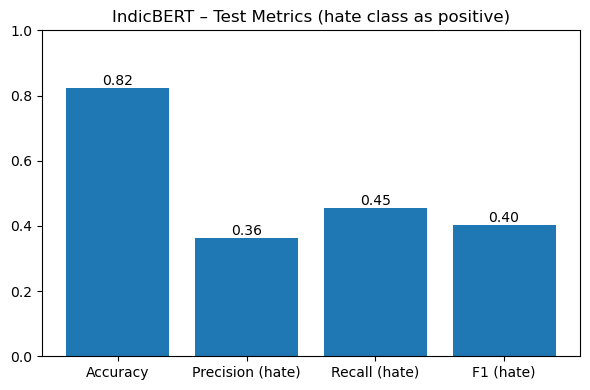

In [55]:
# Printing a bar plot for all metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

metrics = ["Accuracy", "Precision (hate)", "Recall (hate)", "F1 (hate)"]
values = [acc, prec, rec, f1]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values)
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.title("IndicBERT – Test Metrics (hate class as positive)")
plt.tight_layout()
plt.show()


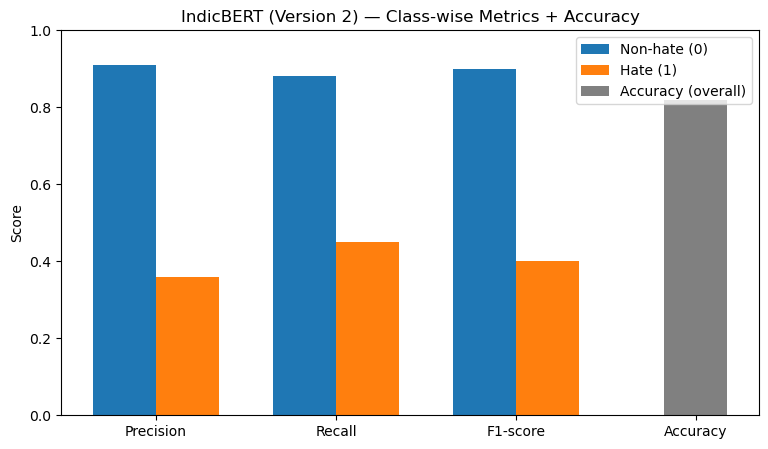

In [57]:
# Class-wise values
metrics = ["Precision", "Recall", "F1-score"]
non_hate = [0.91, 0.88, 0.90]
hate     = [0.36, 0.45, 0.40]

# Overall accuracy
accuracy = 0.82

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,5))

# Class-wise bars
plt.bar(x - width/2, non_hate, width, label="Non-hate (0)")
plt.bar(x + width/2, hate, width, label="Hate (1)")

# Accuracy bar (placed at the right side)
plt.bar(len(metrics), accuracy, width, color="grey", label="Accuracy (overall)")

# Tick labels
plt.xticks(list(x) + [len(metrics)], metrics + ["Accuracy"])
plt.ylim(0, 1)

plt.ylabel("Score")
plt.title("IndicBERT (Version 2) — Class-wise Metrics + Accuracy")
plt.legend()
plt.show()